# Adding in Features from auxillary databases

In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode
from io import StringIO

In [ ]:
df = pd.read_csv('../data/synth_combined.csv', index_col=0)
df

FileNotFoundError: [Errno 2] No such file or directory: '../data/synth_combined_slide100.csv'

***
# IAB

"Das Institut für Arbeitsmarkt und Berufsforschung (IAB) informiert mit "Beruf – Struktur – Entwicklung" (kurz BSE, vormals "Berufe im Spiegel der Statistik") über die sozialversicherungspflichtige Beschäftigung und die registrierte Arbeitslosigkeit in den Berufen in Deutschland. Unter Beruf werden hier nicht Ausbildungsberufe, sondern Erwerbsberufe verstanden, d.h. die ausgeübten bzw. angestrebten Tätigkeiten unabhängig von der absolvierten Ausbildung."

data is extracted by parsing thgrough html tables.

In [ ]:
state_id_map = {
    'BW' : 4,
    'BY' : 5,
    'HB' : 6,
    'HH' : 7,
    'HE' : 8,
    'NI' : 9,
    'NW' : 10,
    'RP' : 11,
    'SL' : 12,
    'SH' : 13,
    'BE' : 15,
    'BB' : 16,
    'MV' : 17,
    'SN' : 18,
    'ST' : 19,
    'TH' : 20
}

In [ ]:
base_url = "https://iab.de/grafiken-und-daten/beruf-struktur-entwicklung/"
params_template = {
    'beruf': 1,  
    'qualifikation': 0, 
    'jahre': '2013,2014,2015,2016,2017,2018,2019,2020,2021,2022'
}

In [ ]:
# Lists to store cleaned DataFrames for each state
all_employment_data = []
all_unemployment_data = []

# --- Data Cleaning Functions ---
# These functions transform the raw HTML tables into a clean, consistent format.

def clean_employment_data(df_raw, state_name):
    """
    Cleans the raw employment DataFrame extracted from HTML.
    Transforms it into a long format, then pivots to a wide format with clean metric names.
    Applies division by 10 to percentage-like columns.
    """
    if df_raw is None or df_raw.empty:
        print(f"    [CLEANING WARNING] Empty raw employment DF for {state_name}")
        return None

    df = df_raw.copy()

    # Drop rows that are clearly section headers (not actual data metrics)
    section_headers_keywords = [
        'Beschäftigtengruppen',
        'Branchenstruktur',
        'Mittleres monatliches',
        'Geschlecht',
        'Alter',
        'Qualifikation',
        'Betriebsgröße'
    ]

    # Filter out rows where 'Unnamed: 0' (our metric column) contains section header keywords
    for keyword in section_headers_keywords:
        df = df[~df['Unnamed: 0'].astype(str).str.contains(keyword, na=False, case=False)].copy()

    # Rename the first column for clarity
    df.rename(columns={'Unnamed: 0': 'Metric'}, inplace=True)

    # Dynamically identify year columns (e.g., '2013', '2014')
    year_cols = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    if not year_cols:
        print(f"    [CLEANING ERROR] No year columns found in employment DF for {state_name}")
        return None

    # Melt the DataFrame from wide to long format
    df_melted = df.melt(id_vars=['Metric'], value_vars=year_cols, var_name='Year', value_name='Value')

    # Add the 'State' column
    df_melted['State'] = state_name

    # Convert 'Value' and 'Year' to numeric types
    # Replace thousands separators (dots) and decimal commas for proper conversion
    df_melted['Value'] = df_melted['Value'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce') # 'coerce' turns unparseable values into NaN
    df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce')

    # Remove rows where numeric conversion failed or metric is missing
    df_melted.dropna(subset=['Value', 'Year', 'Metric'], inplace=True)

    # Define a mapping for original metric names to clean, standardized names
    metric_mapping_emp = {
        'Sozialversicherungspflichtig Beschäftigte (Anzahl)': 'Emp_Total_Count',
        'Bestandsentwicklung Index (2013=100)': 'Emp_Index',
        'Frauen': 'Emp_Women_Share', # Assuming this is a percentage or share
        'Ausländer': 'Emp_Foreign_Share',
        'Unter 25 Jahre': 'Emp_Age_Under_25_Share',
        '25 bis unter 35 Jahre': 'Emp_Age_25_34_Share',
        '35 bis unter 50 Jahre': 'Emp_Age_35_49_Share',
        '50 und älter': 'Emp_Age_50_Plus_Share',
        'Teilzeit': 'Emp_PartTime_Share',
        'Ohne abgeschlossene Berufsausbildung': 'Emp_No_Vocational_Edu_Share',
        'Abschluss einer anerkannten Berufsausbildung': 'Emp_Recognized_Vocational_Edu_Share',
        'Meister-/Techniker- oder gleichwertiger Fachschulabschluss': 'Emp_Master_Tech_Share',
        'Bachelor': 'Emp_Bachelor_Share',
        'Diplom/Magister/Staatsexamen': 'Emp_Diplom_Magister_StateExam_Share',
        'Promotion': 'Emp_Promotion_Share',
        'Berufliche Ausbildung unbekannt': 'Emp_Vocational_Edu_Unknown_Share',
        'Insgesamt': 'Emp_Avg_Gross_Salary_Total', # Assuming under salary section, so not a share
        'Männer': 'Emp_Avg_Gross_Salary_Men', # Not a share
        # Sector-specific employment shares (assuming these are percentages)
        'Land-, Fortswirtschaft, Gartenbau': 'Emp_Sector_Agriculture_Share',
        'Produzierendes Gewerbe': 'Emp_Sector_Manufacturing_Share',
        'darunter: Maschinen-, Farhrzeugbau': 'Emp_Sector_Manufacturing_Machinery_Share',
        'Baugewerbe': 'Emp_Sector_Construction_Share',
        'Übriges produzierendes Gewerbe': 'Emp_Sector_Manufacturing_Other_Share',
        'Dienstleistungssektor': 'Emp_Sector_Services_Share',
        'darunter: Handel': 'Emp_Sector_Services_Trade_Share',
        'Verkehr und Nachrichtenübermittlung': 'Emp_Sector_Services_Transport_Com_Share',
        'Kredit- und Versicherunsgewerbe': 'Emp_Sector_Services_Finance_Insurance_Share',
        'Ingenieurbüros, Rechtsberatung, Werbung, Arbeitnehmerüberlassung': 'Emp_Sector_Services_Professional_Share',
        'Erziehung, Unterricht, Kultur, Sport, Unterhaltung': 'Emp_Sector_Services_Edu_Culture_Share',
        'Gesundheits-, Sozialwesen': 'Emp_Sector_Services_Health_Social_Share',
        'Öffenliche Verwaltung, Sozialversicherung': 'Emp_Sector_Services_Public_Admin_Share',
        'Übrige Dienstleistungen': 'Emp_Sector_Services_Other_Share',
    }

    # Apply the mapping and drop unmapped metrics
    df_melted['Metric_Clean'] = df_melted['Metric'].map(metric_mapping_emp)
    df_melted.dropna(subset=['Metric_Clean'], inplace=True)

    # Pivot back to wide format, with cleaned metrics as columns
    # aggfunc='first' handles potential duplicates by taking the first value found
    df_final = df_melted.pivot_table(index=['Year', 'State'], columns='Metric_Clean', values='Value', aggfunc='first').reset_index()
    df_final.columns.name = None # Remove the 'columns' name above the new columns

    # Identify columns that are shares and divide by 10 (assuming "per thousand" interpretation)
    share_columns = [col for col in df_final.columns if 'Share' in col]
    # Check if 'Avg_Gross_Salary' columns exist and exclude them, as they are not shares
    share_columns = [col for col in share_columns if 'Avg_Gross_Salary' not in col]

    for col in share_columns:
        if col in df_final.columns:
            df_final[col] = df_final[col] / 10
            # Optional: Round to 1 decimal place if desired for percentages
            # df_final[col] = df_final[col].round(1)

    return df_final


def clean_unemployment_data(df_raw, state_name):
    """
    Cleans the raw unemployment DataFrame extracted from HTML.
    Similar process to employment data cleaning.
    Applies division by 10 to percentage-like columns.
    """
    if df_raw is None or df_raw.empty:
        print(f"    [CLEANING WARNING] Empty raw unemployment DF for {state_name}")
        return None

    df = df_raw.copy()

    # Drop rows that are clearly section headers (not actual data metrics)
    section_headers_keywords = [
        'Arbeitlosenquote', # Often appears as a header in the first column
        'Arbeitslosengruppen',
        'Geschlecht',
        'Alter',
        'Qualifikation',
        'Dauer',
        'Rechtskreis'
    ]

    for keyword in section_headers_keywords:
        df = df[~df['Unnamed: 0'].astype(str).str.contains(keyword, na=False, case=False)].copy()

    df.rename(columns={'Unnamed: 0': 'Metric'}, inplace=True)

    year_cols = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    if not year_cols:
        print(f"    [CLEANING ERROR] No year columns found in unemployment DF for {state_name}")
        return None

    df_melted = df.melt(id_vars=['Metric'], value_vars=year_cols, var_name='Year', value_name='Value')
    df_melted['State'] = state_name

    df_melted['Value'] = df_melted['Value'].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce')
    df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce')
    df_melted.dropna(subset=['Value', 'Year', 'Metric'], inplace=True)

    # Define a mapping for unemployment metric names
    metric_mapping_unemp = {
        'Arbeitslose mit desem Zielberuf (Anzahl)': 'Unemp_Total_Count',
        'Bestandsentwicklung Index (2013=100)': 'Unemp_Index_2013_100',
        'Alo-Quote insgesamt': 'Unemp_Rate_Total', # These are rates/percentages, will be divided by 10
        'Alo-Quote Männer': 'Unemp_Rate_Men',
        'Alo-Quote Frauen': 'Unemp_Rate_Women',
        'Frauen': 'Unemp_Women_Share',
        'Ausländer': 'Unemp_Foreign_Share',
        'Unter 25 Jahre': 'Unemp_Age_Under_25_Share',
        '25 bis unter 35 Jahre': 'Unemp_Age_25_34_Share',
        '35 bis unter 50 Jahre': 'Unemp_Age_35_49_Share',
        '50 Jahre und älter': 'Unemp_Age_50_Plus_Share',
        'ohne abgeschlossene Berufsbildung': 'Unemp_No_Vocational_Edu_Share',
        'mit betrieblicher Ausbildung': 'Unemp_Vocational_Training_Share',
        'Bachelor': 'Unemp_Bachelor_Share',
        'Diplom/Magister/Master/Staatsexamen': 'Unemp_Diplom_Magister_Master_StateExam_Share',
        'Promotion': 'Unemp_Promotion_Share',
        'Abschluss unbekannt': 'Unemp_Edu_Unknown_Share',
        '1 Jahr und länger arbeitslos': 'Unemp_LongTerm_Share',
        'SGB III (Arbeitslosenversicherung)': 'Unemp_SGB_III_Share', # Benefits from unemployment insurance
        'SGB II (Grundsicherung für Arbeitsuchende)': 'Unemp_SGB_II_Share', # Basic income support for job seekers
    }
    df_melted['Metric_Clean'] = df_melted['Metric'].map(metric_mapping_unemp)
    df_melted.dropna(subset=['Metric_Clean'], inplace=True)

    df_final = df_melted.pivot_table(index=['Year', 'State'], columns='Metric_Clean', values='Value', aggfunc='first').reset_index()
    df_final.columns.name = None

    # Identify columns that are rates or shares and divide by 10 (assuming "per thousand" interpretation)
    # This applies to Unemp_Rate_Total, Unemp_Rate_Men, Unemp_Rate_Women and all other 'Share' columns
    rate_share_columns = [col for col in df_final.columns if 'Share' in col or 'Rate' in col]

    for col in rate_share_columns:
        if col in df_final.columns:
            df_final[col] = df_final[col] / 10
            # Optional: Round to 1 decimal place if desired for percentages
            # df_final[col] = df_final[col].round(1)

    return df_final

# --- Main Data Scraping and Cleaning Loop ---
for state_name, region_id in state_id_map.items():
    print(f"Processing data for: {state_name}")

    current_params = params_template.copy()
    current_params['region'] = region_id
    query_string = urlencode(current_params)
    full_url = f"{base_url}?{query_string}#iab-results"

    try:
        response = requests.get(full_url)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        html_content = response.text

        dfs = pd.read_html(StringIO(html_content))

        df_employment_raw = None
        df_unemployment_raw = None

        # Identify which table is which based on the first cell's content
        for df_candidate in dfs:
            if not df_candidate.empty and 'Unnamed: 0' in df_candidate.columns:
                metric_header_value = df_candidate.iloc[0, df_candidate.columns.get_loc('Unnamed: 0')]

                if isinstance(metric_header_value, str):
                    clean_metric_header = metric_header_value.strip().lower()
                    if clean_metric_header.startswith('sozialversicherungspflichtig beschäftigte'):
                        df_employment_raw = df_candidate
                        print(f"    Identified EMPLOYMENT table for {state_name}")
                    elif clean_metric_header.startswith('arbeitslose mit desem zielberuf'):
                        df_unemployment_raw = df_candidate
                        print(f"    Identified UNEMPLOYMENT table for {state_name}")


        # Process and clean the identified employment table
        if df_employment_raw is not None:
            try:
                cleaned_emp_df = clean_employment_data(df_employment_raw, state_name)
                if cleaned_emp_df is not None and not cleaned_emp_df.empty:
                    all_employment_data.append(cleaned_emp_df)
                else:
                    print(f"    [CLEANING WARNING] clean_employment_data returned empty or None for {state_name}")
            except Exception as e:
                print(f"    [CLEANING ERROR] Error in clean_employment_data for {state_name}: {type(e).__name__}: {e}")
        else:
            print(f"    Warning: No employment table found for {state_name} based on conditions.")

        # Process and clean the identified unemployment table
        if df_unemployment_raw is not None:
            try:
                cleaned_unemp_df = clean_unemployment_data(df_unemployment_raw, state_name)
                if cleaned_unemp_df is not None and not cleaned_unemp_df.empty:
                    all_unemployment_data.append(cleaned_unemp_df)
                else:
                    print(f"    [CLEANING WARNING] clean_unemployment_data returned empty or None for {state_name}")
            except Exception as e:
                print(f"    [CLEANING ERROR] Error in clean_unemployment_data for {state_name}: {type(e).__name__}: {e}")
        else:
            print(f"    Warning: No unemployment table found for {state_name} based on conditions.")

    except requests.exceptions.RequestException as e:
        print(f"  Error fetching data for {state_name}: {e}")
    except ValueError as e: # read_html raises ValueError if no tables found or parsing fails
        print(f"  Error parsing HTML (no tables found or format issue) for {state_name}: {e}")
    except Exception as e:
        print(f"  An unexpected error occurred for {state_name}: {type(e).__name__}: {e}")

print("\n--- Data Collection Complete ---")

# --- Combine all collected data ---

df_all_employment = pd.DataFrame()
if all_employment_data:
    df_all_employment = pd.concat(all_employment_data, ignore_index=True)
    print("\n--- Consolidated Employment Data Head ---")
    print(df_all_employment.head())
else:
    print("\nNo employment data was successfully collected.")

df_all_unemployment = pd.DataFrame()
if all_unemployment_data:
    df_all_unemployment = pd.concat(all_unemployment_data, ignore_index=True)
    print("\n--- Consolidated Unemployment Data Head ---")
    print(df_all_unemployment.head())
else:
    print("\nNo unemployment data was successfully collected.")

# --- Merge Employment and Unemployment Data into a Single DataFrame ---
df_combined_data = pd.DataFrame()
if not df_all_employment.empty and not df_all_unemployment.empty:
    # Merge on 'Year' and 'State' columns, as these are common identifiers
    df_combined_data = pd.merge(
        df_all_employment,
        df_all_unemployment,
        on=['Year', 'State'],
        how='outer' # Use 'outer' to keep all years/states from both if one is missing
    )
    print("\n--- Combined Employment and Unemployment Data Head (All States) ---")
    print(df_combined_data.head())
    print(f"\nCombined DataFrame shape: {df_combined_data.shape}")
    print(f"Combined DataFrame columns: {df_combined_data.columns.tolist()}")
elif not df_all_employment.empty:
    print("\nOnly employment data available for combination.")
    df_combined_data = df_all_employment # If only employment data, that's the combined
elif not df_all_unemployment.empty:
    print("\nOnly unemployment data available for combination.")
    df_combined_data = df_all_unemployment # If only unemployment data, that's the combined
else:
    print("\nNo data collected for combination.")

# You can now save df_combined_data to CSV, Excel, etc.
# Example: df_combined_data.to_csv('iab_employment_unemployment_data.csv', index=False)

Processing data for: BW
    Identified EMPLOYMENT table for BW
    Identified UNEMPLOYMENT table for BW
Processing data for: BY
    Identified EMPLOYMENT table for BY
    Identified UNEMPLOYMENT table for BY
Processing data for: HB
    Identified EMPLOYMENT table for HB
    Identified UNEMPLOYMENT table for HB
Processing data for: HH
    Identified EMPLOYMENT table for HH
    Identified UNEMPLOYMENT table for HH
Processing data for: HE
    Identified EMPLOYMENT table for HE
    Identified UNEMPLOYMENT table for HE
Processing data for: NI
    Identified EMPLOYMENT table for NI
    Identified UNEMPLOYMENT table for NI
Processing data for: NW
    Identified EMPLOYMENT table for NW
    Identified UNEMPLOYMENT table for NW
Processing data for: RP
    Identified EMPLOYMENT table for RP
    Identified UNEMPLOYMENT table for RP
Processing data for: SL
    Identified EMPLOYMENT table for SL
    Identified UNEMPLOYMENT table for SL
Processing data for: SH
    Identified EMPLOYMENT table for SH
 

In [ ]:
df_combined_data

,Year,State,Emp_Age_25_34_Share,Emp_Age_35_49_Share,Emp_Age_50_Plus_Share,Emp_Age_Under_25_Share,Emp_Bachelor_Share,Emp_Diplom_Magister_StateExam_Share,Emp_Foreign_Share,Emp_Index,...,Unemp_Index_2013_100,Unemp_LongTerm_Share,Unemp_No_Vocational_Edu_Share,Unemp_Promotion_Share,Unemp_Rate_Men,Unemp_Rate_Total,Unemp_Rate_Women,Unemp_Total_Count,Unemp_Vocational_Training_Share,Unemp_Women_Share
0,2013,BB,21.3,36.8,36.4,5.5,1.0,10.4,2.8,100.0,...,100.0,43.2,24.8,0.1,15.1,14.3,13.4,126890.0,63.4,45.3
1,2013,BE,26.2,38.3,29.7,5.7,1.9,17.1,8.8,100.0,...,100.0,33.5,49.2,0.4,16.9,14.9,13.0,208780.0,36.5,43.8
2,2013,BW,22.1,39.1,31.4,7.4,1.7,12.0,11.8,100.0,...,100.0,31.3,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6
3,2013,BY,23.3,39.1,29.1,8.4,1.1,11.9,10.0,100.0,...,100.0,26.7,41.8,0.3,4.8,5.0,5.3,247130.0,46.7,48.2
4,2013,HB,21.1,40.1,32.5,6.3,1.1,12.9,7.1,100.0,...,100.0,44.9,60.2,0.1,11.1,11.4,11.7,37003.0,31.2,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2022,SH,21.3,32.6,38.9,7.1,3.2,9.5,9.6,119.0,...,81.0,37.4,57.2,0.2,7.7,7.3,6.9,78646.0,34.9,45.2
156,2022,SL,21.7,32.3,39.6,6.3,3.0,10.3,14.2,107.0,...,85.0,40.1,62.0,0.1,8.2,7.8,7.3,31654.0,32.3,43.2
157,2022,SN,19.2,36.9,38.1,5.8,3.0,14.7,7.2,111.0,...,61.0,39.2,40.6,0.2,7.1,6.8,6.5,115884.0,50.6,45.8
158,2022,ST,17.9,34.8,41.6,5.7,2.5,10.1,6.3,105.0,...,60.0,39.0,44.3,0.1,9.7,8.9,8.1,75936.0,49.7,44.2


In [ ]:
# --- State Name Conversion (THIS IS THE CORRECTED MAP DIRECTION) ---
# This dictionary maps ABBREVIATIONS (from df_combined_data['State']) to FULL NAMES (for original_dataframe['state'])
abbr_to_full_state_name = {
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "BE": "Berlin",
    "BB": "Brandenburg",
    "HB": "Bremen",
    "HH": "Hamburg",
    "HE": "Hessen",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen", # !!! CRUCIAL CORRECTION: 'NW' to 'Nordrhein-Westfalen' !!!
    "RP": "Rheinland-Pfalz",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "SH": "Schleswig-Holstein",
    "TH": "Thüringen",
    "DE": "Deutschland" # Include Deutschland if it might appear
}

# 1. Convert the 'State' column in df_combined_data from abbreviations to full names
df_combined_data['State_Full'] = df_combined_data['State'].map(abbr_to_full_state_name)

# --- DIAGNOSTIC PRINTS AFTER MAPPING ---
print("\n--- Diagnostic Check: Unique States in df_combined_data AFTER MAPPING ---")
print(df_combined_data['State_Full'].unique())

print("\n--- Diagnostic Check: Data Types of Join Keys (Original DataFrame) ---")
print(df[['year', 'state']].dtypes)
print("\n--- Diagnostic Check: Data Types of Join Keys (Combined Data DataFrame, after mapping) ---")
print(df_combined_data[['Year', 'State_Full']].dtypes)

print("\n--- Diagnostic Check: Sample Data Points for Matching (Post-Mapping) ---")
target_year = 2013
target_state_orig = 'Baden-Württemberg'

print(f"\nChecking for (Year={target_year}, State='{target_state_orig}') in original_dataframe:")
print(df[(df['year'] == target_year) & (df['state'] == target_state_orig)].head())

print(f"\nChecking for (Year={target_year}, State='{target_state_orig}') in df_combined_data (after mapping):")
# Filter using 'State_Full' after mapping
print(df_combined_data[(df_combined_data['Year'] == target_year) & (df_combined_data['State_Full'] == target_state_orig)].head())


# --- PREPARING FOR MERGE (INCLUDING STRIPPING WHITESPACE) ---

# Ensure year columns are numeric (int64) and state columns are string/object
df['year'] = df['year'].astype(int)
df_combined_data['Year'] = df_combined_data['Year'].astype(int)

# Strip any leading/trailing whitespace from state columns
df['state'] = df['state'].astype(str).str.strip()
df_combined_data['State_Full'] = df_combined_data['State_Full'].astype(str).str.strip()


# Rename columns in df_combined_data for merging
df_combined_data_for_merge = df_combined_data.rename(
    columns={'Year': 'year', 'State_Full': 'state'}
)

# --- PERFORM THE MERGE ---

# Drop the original 'State' (abbreviation) column from df_combined_data_for_merge
# And also drop 'State_Abbr' if it somehow got created from previous runs, as it's not needed.
cols_to_drop = ['State'] # This is the original abbreviation column we don't need after mapping to State_Full
if 'State_Abbr' in df_combined_data_for_merge.columns: # Clean up if it exists from previous attempts
    cols_to_drop.append('State_Abbr')

df_final_merged = pd.merge(
    df, # Using 'df' as you did in your code for the original dataframe
    df_combined_data_for_merge.drop(columns=cols_to_drop, errors='ignore'), # 'errors=ignore' prevents error if col doesn't exist
    on=['year', 'state'],
    how='left'
)

print("\n--- Head of the Final Merged DataFrame ---")
print(df_final_merged.head())

print("\n--- Info of the Final Merged DataFrame (to check columns and data types) ---")
df_final_merged.info()

print("\n--- Non-null counts for a few merged columns (SHOULD NOW BE POPULATED!) ---")
print(df_final_merged[['Emp_Age_25_34_Share', 'Unemp_Rate_Total', 'Emp_Total_Count']].count())


--- Diagnostic Check: Unique States in df_combined_data AFTER MAPPING ---
['Brandenburg' 'Berlin' 'Baden-Württemberg' 'Bayern' 'Bremen' 'Hessen'
 'Hamburg' 'Mecklenburg-Vorpommern' 'Niedersachsen' 'Nordrhein-Westfalen'
 'Rheinland-Pfalz' 'Schleswig-Holstein' 'Saarland' 'Sachsen'
 'Sachsen-Anhalt' 'Thüringen']

--- Diagnostic Check: Data Types of Join Keys (Original DataFrame) ---
year      int64
state    object
dtype: object

--- Diagnostic Check: Data Types of Join Keys (Combined Data DataFrame, after mapping) ---
Year           int64
State_Full    object
dtype: object

--- Diagnostic Check: Sample Data Points for Matching (Post-Mapping) ---

Checking for (Year=2013, State='Baden-Württemberg') in original_dataframe:
          age                                 education  year  \
0  18-Jährige  Realschul- oder vergleichbarer Abschluss  2013   
1  20-Jährige  Realschul- oder vergleichbarer Abschluss  2013   
2  19-Jährige  Realschul- oder vergleichbarer Abschluss  2013   
3  19-Jährig

In [ ]:
df_final_merged

,age,education,year,state,gender,sector,nationality,dropped_out,Emp_Age_25_34_Share,Emp_Age_35_49_Share,...,Unemp_Index_2013_100,Unemp_LongTerm_Share,Unemp_No_Vocational_Edu_Share,Unemp_Promotion_Share,Unemp_Rate_Men,Unemp_Rate_Total,Unemp_Rate_Women,Unemp_Total_Count,Unemp_Vocational_Training_Share,Unemp_Women_Share
0,18-Jährige,Realschul- oder vergleichbarer Abschluss,2013,Baden-Württemberg,männlich,Handwerk,Deutsche,1,22.1,39.1,...,100.0,31.3,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6
1,20-Jährige,Realschul- oder vergleichbarer Abschluss,2013,Baden-Württemberg,männlich,Industrie und Handel,Ausländer,1,22.1,39.1,...,100.0,31.3,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6
2,19-Jährige,Realschul- oder vergleichbarer Abschluss,2013,Baden-Württemberg,männlich,Handwerk,Deutsche,1,22.1,39.1,...,100.0,31.3,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6
3,19-Jährige,Ohne Hauptschulabschluss,2013,Baden-Württemberg,männlich,Industrie und Handel,Deutsche,1,22.1,39.1,...,100.0,31.3,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6
4,21-Jährige,Realschul- oder vergleichbarer Abschluss,2013,Baden-Württemberg,männlich,Industrie und Handel,Deutsche,1,22.1,39.1,...,100.0,31.3,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407995,18-Jährige,Hauptschulabschluss,2023,Thüringen,weiblich,Industrie und Handel,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407996,19-Jährige,Im Ausland erworbener Abschluss (nicht zuorden...,2023,Thüringen,weiblich,Freie Berufe,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407997,24 Jahre und mehr,Hauptschulabschluss,2023,Thüringen,weiblich,Handwerk,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407998,17-Jährige,Realschul- oder vergleichbarer Abschluss,2023,Thüringen,weiblich,Freie Berufe,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
# nominal wages

In [ ]:
df_idx = pd.read_csv('../data/destatis/nominalwage_idx.csv')
df_idx

,Jahr,Baden-Württemberg,Bayern,Berlin,Bremen,Hamburg1,Hessen,Nieder­sachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Schleswig-Holstein1,Brandenburg,Mecklenburg-Vorpommern,Sachsen,Sachsen-Anhalt1,Thüringen
0,2024,-,"111,8","112,6",112,112,"112,8","111,9","111,3","108,3","111,8","111,4","112,4","112,5","112,5",112,"111,8"
1,2023,-,"106,2",106,"105,7","105,9","106,2","106,2",106,"103,1","105,7","105,4","106,5","106,2","106,9","106,1","106,6"
2,2022,"(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)","(100,0)"
3,2021,"98,7","97,6","95,3","97,7","95,1",97,98,"97,7","95,8","98,1",97,"96,6","95,5","95,9",95,"95,7"
4,2020,"95,1","94,4","91,8","95,5","91,1","94,4","95,7","94,9","93,2","94,9","94,1","93,8","93,1","92,8","92,3","92,5"
5,2019,"97,9","95,7","90,7","96,1","91,9","95,3","96,6","95,1","93,6","96,7","93,5","92,3","92,4","92,2",91,"92,3"
6,2018,"95,4","93,5","87,3","93,7","89,7","93,1",94,93,"91,5","94,8","91,3","88,8","89,5",89,"87,9",89
7,2017,"92,5","90,3","84,4",91,87,"90,4","91,4","90,7","88,9","92,1","88,7","85,8","86,8","85,9","84,2","86,1"
8,2016,"90,3","88,3","82,1","87,1","84,7","87,8","89,3","88,5","86,9",90,"86,5","83,4","84,3","83,5","81,4","83,5"
9,2015,"88,4","86,6","80,1","85,6","82,8","85,9","87,6","86,3","85,1","88,6","84,5","81,4","81,6","80,8","79,3","81,5"


In [ ]:
df_rate = pd.read_csv('../data/destatis/nominalwage_rate.csv')
df_rate

,Jahr,Baden-Württemberg,Bayern,Berlin,Bremen,Hamburg1,Hessen,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Schleswig-Holstein1,Brandenburg,Mecklenburg-Vorpommern,Sachsen,Sachsen-Anhalt1,Thüringen
0,2024,-,"5,3","6,2",6,"5,8","6,2","5,4",5,5,"5,8","5,7","5,5","5,9","5,2","5,6","4,9"
1,2023,-,"6,2",6,"5,7","5,9","6,2","6,2",6,"3,1","5,7","5,4","6,5","6,2","6,9","6,1","6,6"
2,2022,"(1,3)","(2,5)","(4,9)","(2,4)","(5,2)","(3,1)","(2,0)","(2,4)","(4,4)","(1,9)","(3,1)","(3,5)","(4,7)","(4,3)","(5,3)","(4,5)"
3,2021,"3,8","3,4","3,8","2,3","4,4","2,8","2,4",3,"2,8","3,4","3,1",3,"2,6","3,3",2.9,"3,5"
4,2020,"-2,9","-1,4","1,2","-0,6","-0,9","-0,9","-0,9","-0,2","-0,4","-1,9","0,6","1,6","0,8","0,7","1,4","0,2"
5,2019,"2,6","2,4","3,9","2,6","2,5","2,4","2,8","2,3","2,3",2,"2,4","3,9","3,2","3,6","3,5","3,7"
6,2018,"3,1","3,5","3,4",3,"3,1",3,"2,8","2,5","2,9","2,9","2,9","3,5","3,1","3,6","4,4","3,4"
7,2017,"2,4","2,3","2,8","4,5","2,7",3,"2,4","2,5","2,3","2,3","2,5","2,9",3,"2,9","3,4","3,1"
8,2016,"2,1",2,"2,5","1,8","2,3","2,2","1,9","2,5","2,1","1,6","2,4","2,5","3,3","3,3","2,6","2,5"
9,2015,"2,4","3,1","4,3","2,6","2,3","2,1","2,9","1,9","3,3","2,3","2,5","3,2","4,7","4,3","4,2","3,6"


In [ ]:
def prepare_wage_dataframe(df_raw, value_col_name):
    """
    Cleans column names, processes values, and melts a wide-format wage DataFrame
    into a long format suitable for merging.
    """
    df_processed = df_raw.copy()

    # --- Step 1: Clean 'Jahr' column and rename to 'year' ---
    if 'Jahr' in df_processed.columns:
        df_processed.rename(columns={'Jahr': 'year'}, inplace=True)
    # Handle potential '2024-' format in 'year' column
    df_processed['year'] = df_processed['year'].astype(str).str.replace('-', '', regex=False)
    df_processed['year'] = pd.to_numeric(df_processed['year'], errors='coerce').astype('Int64') # Use Int64 for nullable integer


    # --- Step 2: Clean state column headers ---
    # Apply replacements for common issues found in Destatis tables
    df_processed.columns = df_processed.columns.str.replace(r'Hamburg1', 'Hamburg', regex=True)
    df_processed.columns = df_processed.columns.str.replace(r'Schleswig-Holstein1', 'Schleswig-Holstein', regex=True)
    df_processed.columns = df_processed.columns.str.replace(r'Sachsen-Anhalt1', 'Sachsen-Anhalt', regex=True)
    df_processed.columns = df_processed.columns.str.replace(r'Baden-\nWürttemberg', 'Baden-Württemberg', regex=True)
    df_processed.columns = df_processed.columns.str.replace(r'Nordrhein-\nWestfalen', 'Nordrhein-Westfalen', regex=True)
    df_processed.columns = df_processed.columns.str.replace(r'Rheinland-\nPfalz', 'Rheinland-Pfalz', regex=True) # Added for completeness
    df_processed.columns = df_processed.columns.str.replace(r'Nieder­sachsen', 'Niedersachsen', regex=False) # Fix soft hyphens (U+00AD)
    # Ensure all remaining whitespace is stripped from headers
    df_processed.columns = df_processed.columns.str.strip()


    # --- Step 3: Identify state columns for melting ---
    state_cols = [col for col in df_processed.columns if col != 'year']


    # --- Step 4: Clean data values and convert to numeric ---
    for col in state_cols:
        # Remove parentheses, hyphens, and whitespace
        df_processed[col] = df_processed[col].astype(str).str.replace(r'[()\-\s]', '', regex=True)
        # Replace comma with dot for decimal conversion
        df_processed[col] = df_processed[col].str.replace(',', '.', regex=False)
        # Convert to numeric, coercing errors to NaN
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')


    # --- Step 5: Melt the DataFrame from wide to long format ---
    df_long = df_processed.melt(id_vars=['year'], var_name='state', value_name=value_col_name)


    # --- Step 6: Final cleaning and type conversion for merged dataframe ---
    df_long.dropna(subset=['year', value_col_name], inplace=True) # Drop rows if year or value became NaN
    df_long['year'] = df_long['year'].astype(int) # Final conversion to int for merging
    df_long['state'] = df_long['state'].astype(str).str.strip() # Ensure state names are clean


    return df_long

# --- 2. Apply the function to df_idx and df_rate ---
df_idx_long = prepare_wage_dataframe(df_idx, 'nominal_wage_index')
df_rate_long = prepare_wage_dataframe(df_rate, 'nominal_wage_growth_rate')

print("\n--- Processed df_idx_long Head ---")
print(df_idx_long.head())
print("\n--- Processed df_idx_long Info ---")
df_idx_long.info()

print("\n--- Processed df_rate_long Head ---")
print(df_rate_long.head())
print("\n--- Processed df_rate_long Info ---")
df_rate_long.info()


# --- 3. Prepare main DataFrame for merging (if not already done consistently) ---
# Ensure 'year' and 'state' in your main df are consistent types and stripped.
df_final_merged['year'] = df_final_merged['year'].astype(int)
df_final_merged['state'] = df_final_merged['state'].astype(str).str.strip()


# --- 4. Perform the merges ---

# Merge nominal wage index
df_merged_all_data = pd.merge(
    df_final_merged,
    df_idx_long[['year', 'state', 'nominal_wage_index']],
    on=['year', 'state'],
    how='left'
)

# Merge nominal wage growth rate
df_merged_all_data = pd.merge(
    df_merged_all_data,
    df_rate_long[['year', 'state', 'nominal_wage_growth_rate']],
    on=['year', 'state'],
    how='left'
)

print("\n--- Head of Final Merged DataFrame with all Wage Data ---")
print(df_merged_all_data.head())

print("\n--- Info of Final Merged DataFrame with all Wage Data ---")
df_merged_all_data.info()

print("\n--- Non-null counts for new wage columns ---")
print(df_merged_all_data[['nominal_wage_index', 'nominal_wage_growth_rate']].count())


--- Processed df_idx_long Head ---
   year              state  nominal_wage_index
2  2022  Baden-Württemberg               100.0
3  2021  Baden-Württemberg                98.7
4  2020  Baden-Württemberg                95.1
5  2019  Baden-Württemberg                97.9
6  2018  Baden-Württemberg                95.4

--- Processed df_idx_long Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 2 to 287
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                286 non-null    int64  
 1   state               286 non-null    object 
 2   nominal_wage_index  286 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.9+ KB

--- Processed df_rate_long Head ---
   year              state  nominal_wage_growth_rate
2  2022  Baden-Württemberg                       1.3
3  2021  Baden-Württemberg                       3.8
4  2020  Baden-Württemberg                  

In [ ]:
df_merged_all_data

,age,education,year,state,gender,sector,nationality,dropped_out,Emp_Age_25_34_Share,Emp_Age_35_49_Share,...,Unemp_No_Vocational_Edu_Share,Unemp_Promotion_Share,Unemp_Rate_Men,Unemp_Rate_Total,Unemp_Rate_Women,Unemp_Total_Count,Unemp_Vocational_Training_Share,Unemp_Women_Share,nominal_wage_index,nominal_wage_growth_rate
0,19-Jährige,Hauptschulabschluss,2013,Baden-Württemberg,männlich,Industrie und Handel,Deutsche,1,22.1,39.1,...,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6,84.3,0.7
1,19-Jährige,Hochschul- oder Fachhochschulreife,2013,Baden-Württemberg,männlich,Handwerk,Deutsche,1,22.1,39.1,...,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6,84.3,0.7
2,18-Jährige,Hauptschulabschluss,2013,Baden-Württemberg,männlich,Handwerk,Deutsche,1,22.1,39.1,...,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6,84.3,0.7
3,17-Jährige,Hauptschulabschluss,2013,Baden-Württemberg,männlich,Industrie und Handel,Deutsche,1,22.1,39.1,...,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6,84.3,0.7
4,unter 17 Jahre,Realschul- oder vergleichbarer Abschluss,2013,Baden-Württemberg,männlich,Industrie und Handel,Deutsche,1,22.1,39.1,...,44.6,0.2,5.2,5.4,5.7,227794.0,41.3,47.6,84.3,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351995,unter 17 Jahre,Realschul- oder vergleichbarer Abschluss,2023,Thüringen,weiblich,Handwerk,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.6,6.6
351996,21-Jährige,Hauptschulabschluss,2023,Thüringen,weiblich,Industrie und Handel,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.6,6.6
351997,18-Jährige,Realschul- oder vergleichbarer Abschluss,2023,Thüringen,weiblich,Industrie und Handel,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.6,6.6
351998,18-Jährige,Realschul- oder vergleichbarer Abschluss,2023,Thüringen,weiblich,Industrie und Handel,Deutsche,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.6,6.6


In [ ]:
df_merged_all_data.to_csv('../data/synth_combined_add_features.csv')

In [14]:
df_merged_all_data.corr(numeric_only=True).style.background_gradient()

,year,dropped_out,Emp_Age_25_34_Share,Emp_Age_35_49_Share,Emp_Age_50_Plus_Share,Emp_Age_Under_25_Share,Emp_Bachelor_Share,Emp_Diplom_Magister_StateExam_Share,Emp_Foreign_Share,Emp_Index,Emp_Master_Tech_Share,Emp_No_Vocational_Edu_Share,Emp_PartTime_Share,Emp_Promotion_Share,Emp_Recognized_Vocational_Edu_Share,Emp_Sector_Agriculture_Share,Emp_Sector_Construction_Share,Emp_Sector_Manufacturing_Machinery_Share,Emp_Sector_Manufacturing_Other_Share,Emp_Sector_Manufacturing_Share,Emp_Sector_Services_Edu_Culture_Share,Emp_Sector_Services_Finance_Insurance_Share,Emp_Sector_Services_Health_Social_Share,Emp_Sector_Services_Other_Share,Emp_Sector_Services_Public_Admin_Share,Emp_Sector_Services_Share,Emp_Sector_Services_Trade_Share,Emp_Sector_Services_Transport_Com_Share,Emp_Total_Count,Emp_Vocational_Edu_Unknown_Share,Emp_Women_Share,Unemp_Age_25_34_Share,Unemp_Age_35_49_Share,Unemp_Age_50_Plus_Share,Unemp_Age_Under_25_Share,Unemp_Bachelor_Share,Unemp_Diplom_Magister_Master_StateExam_Share,Unemp_Edu_Unknown_Share,Unemp_Foreign_Share,Unemp_Index_2013_100,Unemp_LongTerm_Share,Unemp_No_Vocational_Edu_Share,Unemp_Promotion_Share,Unemp_Rate_Men,Unemp_Rate_Total,Unemp_Rate_Women,Unemp_Total_Count,Unemp_Vocational_Training_Share,Unemp_Women_Share,nominal_wage_index,nominal_wage_growth_rate
year,1.000000,-0.000000,-0.126788,-0.708955,0.511700,0.036236,0.669822,0.154090,0.428091,0.726634,0.128174,0.266044,0.649415,0.506106,-0.140338,-0.034039,0.014057,-0.059731,-0.124803,-0.105447,0.092944,-0.164596,0.220433,0.109482,-0.011440,0.108509,-0.125509,0.062161,0.053048,-0.566491,-0.012856,-0.191079,-0.024064,0.061471,0.076238,0.284960,-0.395236,-0.454298,0.440372,-0.329145,-0.088778,0.330126,0.202031,-0.299023,-0.349730,-0.409416,-0.046462,-0.274719,-0.389427,0.941465,0.429145
dropped_out,-0.000000,1.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Emp_Age_25_34_Share,-0.126788,0.000000,1.000000,0.100150,-0.687234,0.089101,0.533849,0.781569,0.483881,0.410398,-0.604743,0.292754,-0.034407,0.614192,-0.790098,-0.578609,-0.620781,-0.085773,-0.449266,-0.462812,0.481566,0.462790,-0.562038,0.713011,-0.511093,0.542416,-0.048450,0.063711,0.213944,0.469122,-0.029053,0.689368,0.435995,-0.498232,-0.241086,0.564778,0.682163,-0.043760,0.483627,0.396238,-0.406094,0.265816,0.767470,-0.044808,-0.053964,-0.064510,0.169982,-0.427752,0.084572,-0.179077,0.059263
Emp_Age_35_49_Share,-0.708955,-0.000000,0.100150,1.000000,-0.718916,0.080897,-0.336261,0.153983,-0.187999,-0.493862,-0.340753,-0.144496,-0.399954,-0.217216,-0.147075,-0.176375,-0.237441,-0.025277,-0.077215,-0.114051,-0.010605,0.392497,-0.368821,0.103092,-0.191215,0.138043,0.169595,0.136006,0.008952,0.618634,-0.110590,-0.031192,0.404408,-0.264240,0.032358,-0.206732,0.361753,0.347005,-0.191609,0.211716,0.033729,-0.106974,0.034929,0.041090,0.090387,0.154531,0.068134,0.019639,0.393715,-0.613683,-0.113546
Emp_Age_50_Plus_Share,0.511700,-0.000000,-0.687234,-0.718916,1.000000,-0.423358,-0.159367,-0.525512,-0.363637,-0.008490,0.672869,-0.324180,0.330823,-0.272146,0.665996,0.619497,0.658333,-0.124839,0.255915,0.245304,-0.156781,-0.666734,0.690908,-0.457426,0.601839,-0.336321,-0.234361,-0.059912,-0.291173,-0.706131,0.303465,-0.357765,-0.639679,0.583602,-0.060296,-0.236583,-0.623659,-0.215856,-0.354243,-0.521471,0.327639,-0.281319,-0.577216,0.193084,0.151532,0.090466,-0.224385,0.435391,-0.406131,0.398347,0.108742
Emp_Age_Under_25_Share,0.036236,-0.000000,0.089101,0.080897,-0.423358,1.000000,0.167740,-0.118681,0.607317,0.238122,-0.301528,0.754684,-0.183397,0.133911,-0.317857,-0.513284,-0.434378,0.607653,0.1

<Axes: >

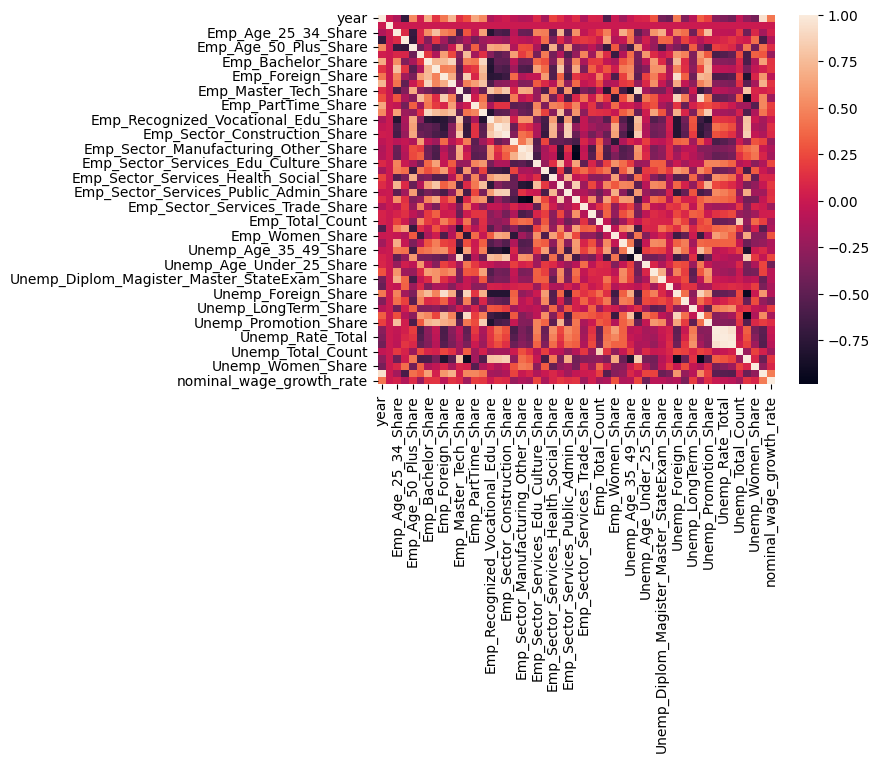

In [15]:
import seaborn as sns
sns.heatmap(df_merged_all_data.corr(numeric_only=True))

In [18]:
sns.pairplot(df_merged_all_data)

: 

In [50]:
df_group_size = pd.DataFrame(df_merged_all_data.groupby(['year', 'state', 'nationality', 'gender', 'age', 'education', 'sector']).size(), columns=['group size']).sort_values('group size', ascending=False)
df_group_size

group size
year state           nationality gender   age               education                                sector                          
2014 Sachsen-Anhalt  Deutsche    weiblich 24 Jahre und mehr Realschul- oder vergleichbarer Abschluss Industrie und Handel         304
2015 Sachsen-Anhalt  Deutsche    weiblich 24 Jahre und mehr Realschul- oder vergleichbarer Abschluss Industrie und Handel         288
2013 Sachsen-Anhalt  Deutsche    weiblich 24 Jahre und mehr Realschul- oder vergleichbarer Abschluss Industrie und Handel         272
2016 Sachsen-Anhalt  Deutsche    weiblich 24 Jahre und mehr Realschul- oder vergleichbarer Abschluss Industrie und Handel         253
2014 Sachsen         Deutsche    männlich 17-Jährige        Realschul- oder vergleichbarer Abschluss Industrie und Handel         253
...                                                                                                                               ...
2013 Thüringen       Deutsche    männlich 23-Jährige        Hochschul- oder Fachhochschulreife       Landwirtschaft                 1
2021 Rheinland-Pfalz Ausländer   weiblich 24 Jahre und mehr Ohne Hauptschulabschluss                 Freie Berufe                   1
                                                            Hochschul- oder Fachhochschulreife       Öffentlicher Dienst            1
                                                                                                     Handwerk                       1
                                          23-Jährige        Realschul- oder vergleichbarer Abschluss Industrie und Handel           1

[91309 rows x 1 columns]